# Practicing Feedback Control

In this unit we are going to explore basic feedback control on a highly simplified, 1-dimensional model of the quadrotor-camera system.

## Simple Slide Camera

Imagine a camera attached to a cart that is allowed to slide along a 1-dimensional track. The track is elevated some height $h$ above the ground and the camera is pointing downward. There is some target on the ground that the camera can observe; more specifically the camera can measure the angle $-\pi /2 < \gamma < \pi/2$ from the centerline of the camera to the target. The objective is to issue velocity commands, $v_{cmd}$, in order to move the cart to a position such that $\gamma \rightarrow \gamma_{des}$ (e.g. if $\gamma_{des} = 0$, then the objective is simply to move the cart directly over the target.

This system is depicted in the below diagram:

<img src="files/simple_slide_camera.jpg">

This somewhat contrived system can be thought of as a highly simplified model of the quadrotor and it's downward-facing camera. If the quadrotor is constrained to move in one dimension, can be controlled via velocity commands, and we ignore the pitch that is induced when changing velocity (valid assumption for low-acceleration maneuvers), then we can roughly model the quadrotor as this simple slide camera

Note that the position of the cart, $x$, and position of the target $x_{des}$ are not directly measured, only $\gamma$ is measured.

Now we will provide the code necessary to simulate this system

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

_HEIGHT = 1.0
_VEL_CONST = 1.0
_TIME_STEP = 0.1

## Plant Dynamics, Sensors, and Actuators

the following object contains functions for the plant dynamics, sensing of the target angle $\gamma$, and actuator for $v_{cmd}$

In [2]:
class SimpleSlideCamera():
    '''Object that defines the dynamics of the simple slide-camera'''

    def __init__(self, x_0, v_0, x_d, gamma_d=0.0, h=_HEIGHT):

        # state variables (hidden)
        self.__x = x_0
        self.__v = v_0

        # reference position (hidden)
        self.__x_d = x_d

        # reference angle (observed)
        self.gamma_d = gamma_d

        # parameters
        self.__h = h

    def sense_gamma(self):
        # calculate angle from camera center line to target
        return  np.arctan2(self.__x - self.__x_d, self.__h)

    def _get_hidden_position(self):

        return self.__x

    def _get_hidden_position_desired(self):
        return self.__x_d

    def _get_hidden_velocity(self):
        return self.__v

    def actuate_velocity_command(self, vel_cmd, dt=_TIME_STEP):
        self.__v = vel_cmd
        self.__x += self.__v*dt

    def actuate_disturbed_velocity_command(self, vel_cmd, dt=_TIME_STEP, vel_bias=0.5, vel_std=0.1):
        self.__v = vel_cmd + np.random.normal(vel_bias, vel_std)
        self.__x += self.__v*dt

    def actuate_acceleration_command(self, acc_cmd, dt=_TIME_STEP):
        self.__v += acc_cmd*dt
        self.__x += self.__v*dt

## Controller

In [3]:
def p_control(y_err, kp):
    """Proportional control law.

    Parameters
    ----------
    y_err : float
        Error signal y_des - y.
    kp : float
        Proportional gain.

    Returns
    -------
    cmd : float
        Control command (e.g. velocity).
    """
    # Proportional term
    cmd = kp * y_err
    return cmd


In [4]:
# p_control tests
assert np.isclose(p_control(0.0, 1.0), 0.0)
assert np.isclose(p_control(1.0, 1.0), 1.0)
assert np.isclose(p_control(-10.0, 0.1), -1.0)

## Simulation Script

below is a script for testing various controllers for the `SimpleSlideCamera` plant as well as plotting the results.

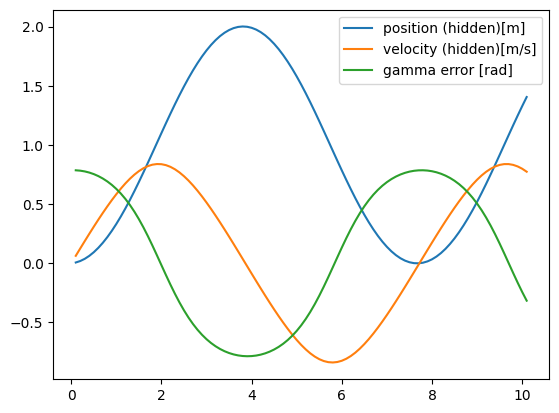

In [5]:
# Proportional gain
kp = 0.8  # tuned by simple trial‑and‑error for quick convergence without overshoot


# Control inputs
dt = _TIME_STEP
t_final = 10.0

# intial conditions (position, velocity and target position)
x_0 = 0.0
v_0 = 0.0
x_des = 1.0

# create SimpleSlideCamera with initial conditions
sscam = SimpleSlideCamera(x_0, v_0, x_des)

# initialize data storage
data = dict()
data['t'] = []
data['acc_cmd'] = []
data['vel_cmd'] = []
data['err_gamma'] = []
data['x_hidden'] = []
data['v_hidden'] = []
t = 0.0
err_prev = 0.0
while t < t_final:
    t += dt

    # SENSOR: sense output variable gamma (angle from camera centerline to target) and calculate error from desired
    err_gamma = sscam.gamma_d - sscam.sense_gamma()

    # CONTROLLER: call velocity control algoritm
    vel_cmd = p_control(err_gamma, kp)

    # ACTUATOR: send velocity command to plant
    sscam.actuate_acceleration_command(vel_cmd)

    # store data
    err_gamma_prev = err_gamma
    data['t'].append(t)
    data['vel_cmd'].append(vel_cmd)
    data['err_gamma'].append(err_gamma)
    data['x_hidden'].append(sscam._get_hidden_position())
    data['v_hidden'].append(sscam._get_hidden_velocity())

# Plot Data
handle_position, = plt.plot(data['t'], data['x_hidden'], label='position (hidden)[m]')
handle_velocity, = plt.plot(data['t'], data['v_hidden'], label='velocity (hidden)[m/s]')
handle_err_gamma, = plt.plot(data['t'], data['err_gamma'], label='gamma error [rad]')
plt.legend(handles=[handle_position, handle_velocity, handle_err_gamma])
plt.show()

## Questions

__Q1.__ Does your gamma error (i.e. output converge to 0.0?
    - If so how quickly (i.e. how long does it take for the error to be 5% of the original error)
    - If not, what is happening? Is the error never changing or is it oscillating back and forth across zero? Can you change the proportional gain kp to change this behavior?


Yes, it converges to zero. It takes around 1.8 seconds to be withing 5% of the original error with kp=2.0. Increasing the kp to 10.0 has it converge almost immediately, but past that it starts to oscillate. Lowering the value to 0.5 makes it take much longer to converge.

__Q2.__ What values should your system's position and velocity be converging upon? Since this is a practice problem and we want to gain understanding of how this system behaves, we've cheated and let you observe the position and velocity of the system which were meant to be unobservable in the real world. Are the position and velocity converging to values you expected?


Position should converge to some constant value indicating that the camera is staying right above its target with gamma equals to zero. Velocity should converge to zero since the target is not moving and if the position is constant velocity will equal zero.

__Q3.__ As you increase the proportional gain, what happens to the rate at which the error converges to zero?

Can you find a proportional gain that converges within 1 second (i.e error reaches 5% of it's original value)? Note: if you start to see an oscillatory, saw-tooth pattern, you're gain is too high.


Yes. 10.0 has it converge very quickly.

__Q4.__ What happens if you cannot perfectly control the velocity, for example there is some form of velocity disturbance that you cannot control (e.g. wind, actuator noise)? Let's try it out:

In the #ACTUATOR portion of the simulation script, replace `actuate_velocity_command` with `actuate_disturbed_velocity_command`, restart the kernel, and run the script. Does output error (gamma error) still converge to zero? If not, what does the gamma error converge to? How might you change your controller to fix this "steady state error"

The error gets close to zero but then starts to fluctuate slightly with the velocity being unpredictable. This could be fixed by accounting for the interference as much as possible. Given the average interference or something similar, we could compensate for the interference by altering the inputs.

__Q5.__ Often times we control a system by applying a force. In this way we are not directly controlling the velocity of a system, but instead the acceleration. Let's try it out:

In the ACTUATOR portion of the simulation script replace `actuate_velocity_command` with `actuate_acceleration_command`. In the CONTROLLER portion of the script, have the controller output a acc_cmd instead of vel_cmd (just change the variable name, but this way you know it represents an acceleration instead of a velocity). Restart the kernel and rerun the script

Now what is happening to the gamma error, is it converging to zero? If not, is there anything you could think of to change in you controller in order to converge the error to zero?

It is not converging. Just using proportional control makes it impossible for velocity to be zero at the point of zero error; it propetually oscillates in simple harmonic motion. 


# ✈️ Altitude PID for a 1‑D “Quadcopter”

Follow the instructions below to design and tune a PID controller that tracks a two‑segment altitude profile.

Your quadcopter can **only move along the $z$‑axis**.  
Track this reference altitude:

| Time [s] | Desired $z$ [m] |
|:-------:|:---------------:|
| 0 – 5   | **2.0** |
| 5 – 10   | **0.5** |


### 1  Model & dynamics

Continuous equation  

$$ m\ddot z = -mg + T, \qquad T = k_T\,u, \; 0\le u\le 1 $$

Euler step (`plant_step`)  

```python
vz += (-g + k_T*u/m) * dt
z  += vz * dt
```



Below is the base setup for a quadcopter under gravity

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---------------------------------------------------------
m   = 1.0     # kg
g   = 9.81    # m/s²
k_T = 15.0    # N  (full-throttle thrust)

def plant_step(z, vz, u, dt):
    """Euler integrate 1‑D quad dynamics."""
    acc = -g + k_T * u / m
    vz += acc * dt
    z  += vz * dt
    return z, vz


### 2  PID controller

Once done with coding the simulation loop, return back to this cell and tune the different parameters

In [16]:
def pid_control(err, err_int, err_dot, kp, ki, kd):
    """PID with throttle clipping in [0, 1].

    The caller should disable integral accumulation when
    the output saturates (anti‑wind‑up).
    """
    u = kp*err + ki*err_int + kd*err_dot
    return np.clip(u, 0.0, 1.0)

# initial gains (tune!)
kp, ki, kd = 1.5, 0.8, 0.40


### 3  Simulation loop

This simulates the drone's height over time, while changing the thrust according to your PID controller

In [17]:
#Variable setup
dt, t_end = 0.02, 10.0
z = vz = 0.0
err_int = err_prev = 0.0
log_t, log_z, log_vz, log_u, log_err = [], [], [], [], []

# --- main loop ---
t = 0.0
while t < t_end:
    z_des = 2.0 if t < 5.0 else 0.5
    err   = z_des-z
    err_int += err*dt
    err_dot = (err-err_prev)/dt
    u = pid_control(err, err_int, err_dot, kp, ki, kd)

    z, vz = plant_step(z, vz, u, dt)

    # log
    log_t.append(t); log_z.append(z); log_vz.append(vz)
    log_u.append(u); log_err.append(err)
    err_prev = err
    t += dt


### 4  Visualisation

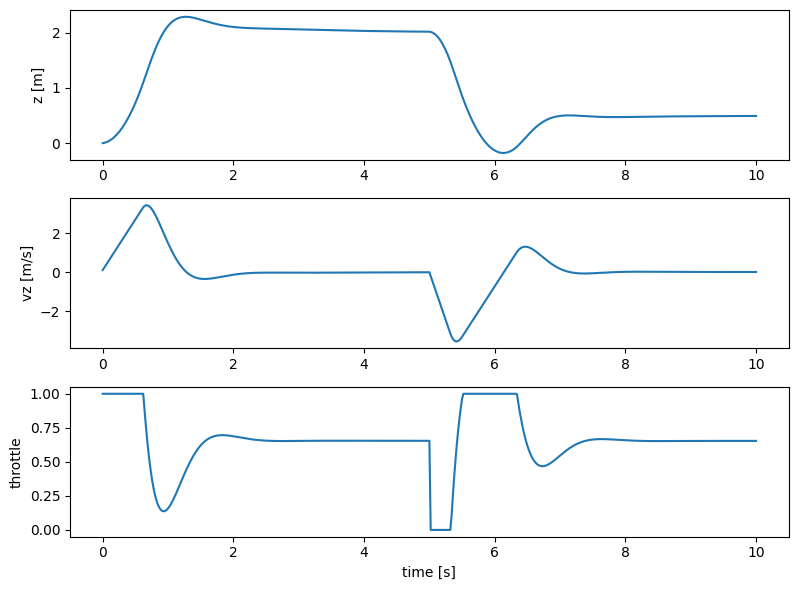

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.subplot(3,1,1); plt.plot(log_t, log_z); plt.ylabel('z [m]')
plt.subplot(3,1,2); plt.plot(log_t, log_vz); plt.ylabel('vz [m/s]')
plt.subplot(3,1,3); plt.plot(log_t, log_u); plt.ylabel('throttle'); plt.xlabel('time [s]')
plt.tight_layout(); plt.show()


# Quadcopter in two dimentions

The math is exactly the same, but now with vectors instead of scalars

Your quadcopter can move only in the X and Y directions at relatively low speeds (it stays flat). Your mission is to catch (be within 10cm of) a particle moving with constant velocity in a windy environement.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---------------------------------------------------------
m   = 1.0     # kg
k_T = 15.0    # N  (full-throttle thrust)

w_x_bias = 5.0 #Wind vector params
w_x_std = 5.0
w_y_bias = 3.2
w_y_std = 0.15

v_ball = np.array([2*np.random.normal(0, 5), 2*np.random.normal(0, 5)])
def plant_step(s, v, u, dt, s_ball):
    """Euler integrate 2‑D quad dynamics."""
    F_w = np.array([np.random.normal(w_x_bias, w_x_std), np.random.normal(w_y_bias, w_y_std)]) #Force of wind
    F_T = k_T * u
    a = F_T/m
    v += a * dt
    s  += v * dt
    s_ball += v_ball*dt
    return s, v, s_ball


In [20]:
def pid_control(err, err_int, err_dot, kp, ki, kd):
    """PID with throttle clipping in [0, 1].

    The caller should disable integral accumulation when
    the output saturates (anti‑wind‑up).
    """
    u = kp*err + ki*err_int + kd*err_dot
    return np.clip(u, -1.0, 1.0)
# initial gains (tune!)
kp, ki, kd = 1.5, 0.6, 0.60


In [21]:
#Variable setup
dt, t_max = 0.1, 15.0
s = np.array([0.0, 0.0])
v = np.array([0.0, 0.0])
err_int = err_prev = np.array([0.0, 0.0])
log_t, log_s, log_v, log_u, log_err, log_s_ball = [], [], [], [], [], []
s_ball = np.array([10*np.random.rand(), 10*np.random.rand()])

# --- main loop ---
t = 0.0
while t < t_max:
    s_des = s_ball
    err   = s_des-s
    err_int += err*dt
    err_dot = (err-err_prev)/dt
    u = pid_control(err, err_int, err_dot, kp, ki, kd)
    s, v, s_ball = plant_step(s, v, u, dt, s_ball)
    log_t.append(t); log_s.append(s.copy()); log_v.append(v.copy())
    log_u.append(u.copy()); log_err.append(err); log_s_ball.append(s_ball.copy())
    err_prev = err
    t += dt
    if np.linalg.norm(s_ball-s)<0.1:
        print(f"Time to catch:{t}")
        break


Time to catch:0.7999999999999999


<Figure size 800x600 with 0 Axes>

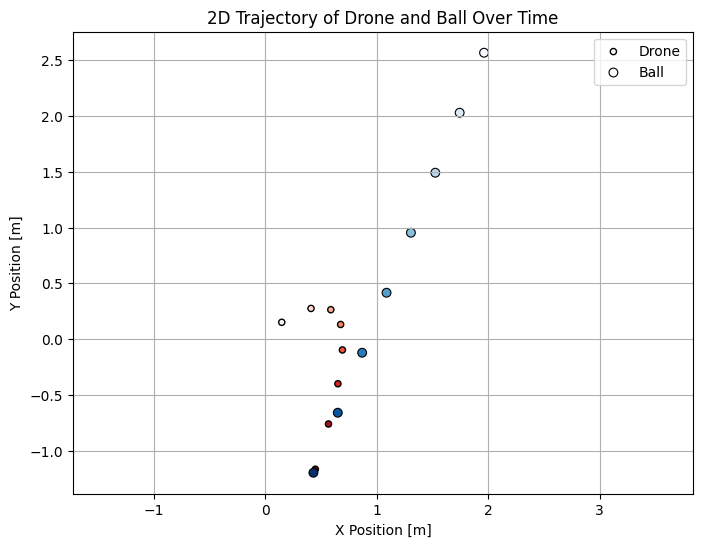

In [22]:
log_s = np.array(log_s)
log_v = np.array(log_v)
log_u = np.array(log_u)
log_t = np.array(log_t)

plt.figure(figsize=(8,6))

from matplotlib import cm

log_s = np.array(log_s)
log_s_ball = np.array(log_s_ball)
log_t = np.array(log_t)

t_norm = (log_t - log_t[0]) / (log_t[-1] - log_t[0])

drone_colors = cm.Reds(t_norm)
ball_colors = cm.Blues(t_norm)

plt.figure(figsize=(8, 6))

# Drone with red shades and black edge
plt.scatter(log_s[:, 0], log_s[:, 1], c=drone_colors, s=20, label="Drone", edgecolor='k')

# Ball with blue shades, circle marker, black edge for visibility
plt.scatter(log_s_ball[:, 0], log_s_ball[:, 1], c=ball_colors, s=40, marker='o',
            label="Ball", edgecolor='k', linewidth=0.8)

plt.xlabel("X Position [m]")
plt.ylabel("Y Position [m]")
plt.title("2D Trajectory of Drone and Ball Over Time")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

